#**Project Ironia**
In this project we are going to compute a robot advisor mutual fund.
For this we are going to follow the next steps:


1.   First we are going to download the data from bigquery (our data was given in that format). This is done through the library bigquery.
2.   When the data is well requested we are going to start making calculations with it.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import datetime
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

plt.rcParams["figure.figsize"] = (18,5)


In [2]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [3]:
from google.cloud import bigquery
import os     
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/IronIA/ironia-data-dfc6335a0abe.json"

ModuleNotFoundError: No module named 'google'

In [5]:
client = bigquery.Client()

# Loading Datasets
In this part we are initializing our request for each of the tables in our dataset.

In [ ]:
# RATIOS
sql_ratios = """
    SELECT * FROM `ironia-data.Ironia_Ext.ratios` LIMIT 1000
"""
df_ratios = pd.read_gbq(sql_ratios)

# CATEGORIES
sql_categories = """
    SELECT * FROM `ironia-data.Ironia_Ext.categories` LIMIT 1000
"""
df_categories = pd.read_gbq(sql_categories)

# PRECIOS
sql_precios = """
    SELECT * FROM `ironia-data.Ironia_Ext.precios` LIMIT 1000
"""
df_precios = pd.read_gbq(sql_precios)


### Exploratory analysis with one sample

In [ ]:
df_precios.loc[df_precios["Ironia_id"]==41319]

,Ironia_id,currency,date,nav,name
0,41319,CAD,2020-03-31,1.1659,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
2,41319,CAD,2017-09-12,0.9933,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
3,41319,CAD,2020-01-28,1.3768,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
4,41319,CAD,2019-08-21,1.2501,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
5,41319,CAD,2019-06-14,1.2404,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
6,41319,CAD,2017-10-02,1.0337,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
7,41319,CAD,2017-09-04,0.9980,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"
8,41319,CAD,2020-03-05,1.3086,"ARDEVORA GLOBAL LONG- ""C"" (CAD)"


In [ ]:
sql = "SELECT nav,date FROM `ironia-data.Ironia_Ext.precios` WHERE Ironia_id=41319 LIMIT 10000 "
df = pd.read_gbq(sql)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")
df.set_index(df["date"],inplace=True)
df.drop("date",axis=1,inplace=True)
df.head(10)

,nav
date,
2017-07-19,1.0041
2017-07-20,1.0005
2017-07-21,0.9961
2017-07-24,0.9946
2017-07-25,0.9991
2017-07-26,0.9997
2017-07-27,0.9971
2017-07-28,0.9872
2017-07-31,0.9927


In [ ]:
df["nav return"] = (df["nav"]-df["nav"].shift(1))/df["nav"].shift(1)
df["nav return"][0] = 0
risk = 0.05
VaR = np.percentile(df["nav return"],risk*100) #VaR at 5% risk
CVaR = np.mean(df["nav return"].loc[df["nav return"]<=VaR])

In [ ]:
df

,nav,nav return
date,,
2017-07-19,1.0041,0.000000
2017-07-20,1.0005,-0.003585
2017-07-21,0.9961,-0.004398
2017-07-24,0.9946,-0.001506
2017-07-25,0.9991,0.004524
...,...,...
2020-09-29,1.4601,0.000685
2020-09-30,1.4621,0.001370
2020-10-01,1.4659,0.002599


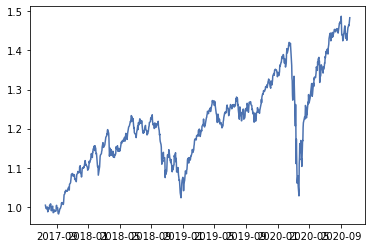

In [ ]:
plt.plot(df["nav"])

In [ ]:
max_acum = df["nav"].cummax()
max_acum.head(5)

date
2017-07-19    1.0041
2017-07-20    1.0041
2017-07-21    1.0041
2017-07-24    1.0041
2017-07-25    1.0041
Name: nav, dtype: float64

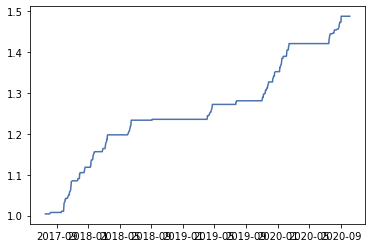

In [ ]:
plt.plot(max_acum)

In [ ]:
df["drawdown"] = -(df["nav"]-max_acum)/max_acum
df.head(5)

,nav,nav return,drawdown
date,,,
2017-07-19,1.0041,0.000000,-0.000000
2017-07-20,1.0005,-0.003585,0.003585
2017-07-21,0.9961,-0.004398,0.007967
2017-07-24,0.9946,-0.001506,0.009461
2017-07-25,0.9991,0.004524,0.004980


Max drawdown: 0.2764324933126848


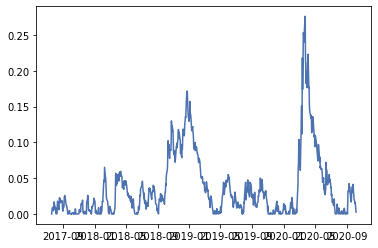

In [ ]:
#Ask if we have to put the drawdown in positive or negative
plt.plot(df["drawdown"])
MDD =  np.max(df["drawdown"].values)
print("Max drawdown:", MDD)


In [ ]:
recovery_factor = df["nav"].iloc[-1]/np.max(df["drawdown"].values)
recovery_factor   

5.367314031066972

In [ ]:
DaR = np.percentile(df["drawdown"],0.7*100)
CDaR = np.mean(df["drawdown"].loc[df["drawdown"]<=DaR])

In [ ]:
MAD = df["nav return"].mad()

In [ ]:
df2 = pd.DataFrame({"Ironia_id": [41319],
                               "MDD": [MDD],
                            "DaR":[DaR],
                           "CDaR": [CDaR],
                         "RF": [recovery_factor],
                          "VaR": [VaR],
                            "CVaR": [CVaR],
                    "MAD":[MAD]})



In [ ]:
df2

,Ironia_id,MDD,DaR,CDaR,RF,VaR,CVaR,MAD
0,41319,0.276432,0.040145,0.013135,5.367314,-0.013824,-0.025778,0.006793


# Dataframe pipeline
Here we are creating a dataframe with all the data we need and we are calculating some data that we need to keep going with the project.

In [ ]:
def generate_df(ids,working_dates,period=1,risk=0.05):

  pd.options.mode.chained_assignment = None

  main_df = pd.DataFrame(columns=["Ironia_id","Name","MDD","DaR","CDaR","RF","VaR", "CVaR", "MAD"])

  prices_df = pd.DataFrame()

  for i in ids:
    sql = f'SELECT nav,date,name FROM `ironia-data.Ironia_Ext.precios` WHERE Ironia_id={i[0]} and date BETWEEN "2016-01-01" and "2018-12-31" LIMIT 10000 '
    df = pd.read_gbq(sql)
    df.dropna(inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(by="date",inplace=True)
    df.set_index(df["date"],inplace=True)

    if len(df) >= len(working_dates): #Number of working days from 2016 to 2018

      try:
        df = df.loc[working_dates]
        df["nav"] = df["nav"].interpolate(method="linear")
        full_series = True
      
      except:
        full_series = False
      
      if full_series:
        prices_df = pd.merge(prices_df,df["nav"],how="outer", left_index=True, right_index=True)
        prices_df.rename(columns={'nav':df["name"].values[0] }, inplace=True)

        prices_df = prices_df.interpolate(method="linear")


        last_date = date.fromisoformat(str(df[-1:].index.values)[2:12])
        years_ago = (last_date - relativedelta(years=period)).isoformat()
  
        df = df[years_ago:last_date]

        df.drop("date",axis=1,inplace=True)
        df["nav return"] = (df["nav"]-df["nav"].shift(1))/df["nav"].shift(1)
        df["nav return"][0] = 0
        VaR = np.percentile(df["nav return"],risk*100) 
        CVaR = np.mean(df["nav return"].loc[df["nav return"]<=VaR])
        max_acum = df["nav"].cummax()
        df["drawdown"] = -(df["nav"]-max_acum)/max_acum
        MDD =  np.max(df["drawdown"].values)
        recovery_factor = df["nav"].iloc[-1]/np.max(df["drawdown"].values)
        DaR = np.percentile(df["drawdown"],risk*100)
        CDaR = np.mean(df["drawdown"].loc[df["drawdown"]<=DaR])
        MAD = df["nav return"].mad()
        main_df = main_df.append({"Ironia_id":int(i[0]),"Name":df["name"].values[0],"MDD":MDD,"DaR":DaR,"CDaR":CDaR,"RF":recovery_factor,"VaR":VaR, "CVaR":CVaR, "MAD":MAD}, ignore_index=True)
      
  return [main_df,prices_df]

In [ ]:
def get_train_test_prices(ids,working_dates_all,start="2016-01-01",train_span="2018-12-31",test_span="2019-12-31",delta=0,print_every=100):

  pd.options.mode.chained_assignment = None

  index = pd.date_range(start=start,end=test_span)
  prices_df = pd.DataFrame(index=index,columns=["Init_"])

  for count,i in enumerate(ids):
    sql = f'SELECT nav,date,name FROM `ironia-data.Ironia_Ext.precios` WHERE Ironia_id={i[0]} and date BETWEEN "{start}" and "{test_span}" LIMIT 10000 '
    df = pd.read_gbq(sql)
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(by="date",inplace=True)
    df.set_index(df["date"],inplace=True)

    if ((count+1) % print_every) == 0:
      print(count+1,"out of",len(ids))

    if len(df) >= (len(working_dates_all) - delta) : #Number of working days from 2016 to 2019, the delta is to admit series with more NaNs
      
      prices_df = pd.merge(prices_df,df["nav"],how="outer", left_index=True, right_index=True)
      prices_df.rename(columns={'nav':df["name"].values[0] }, inplace=True)
      prices_df = prices_df.loc[working_dates_all]

      prices_df = prices_df.interpolate(method="linear")
      
  test_start = date.fromisoformat(train_span)
  test_start = (test_start + relativedelta(days=1)).isoformat()
  prices_df.drop("Init_",inplace=True,axis=1)
  prices_df.dropna(axis='columns',inplace=True)

  return [prices_df[start:train_span],prices_df[test_start:test_span]]

In [ ]:
ids_sql = 'SELECT DISTINCT Ironia_id,name FROM `ironia-data.Ironia_Ext.precios`  WHERE currency="EUR"  LIMIT 10'
ids_sql = 'SELECT DISTINCT allfunds_id FROM `ironia-data.Ironia_Ext.ratios` LIMIT 200'
ids_df = pd.read_gbq(ids_sql)
ids = ids_df.values.tolist()

NameError: name 'ids' is not defined

In [ ]:
with open('/content/drive/MyDrive/IronIA/working_dates.txt') as f:
    contents = f.read()
working_dates = contents.split("\n")[:-1] #Working dates just for train

with open('/content/drive/MyDrive/IronIA/working_dates_train&test.txt') as f:
    contents = f.read()
working_dates_traintest = contents.split("\n")[:-1] #Working dates for both

In [ ]:
train,test = get_train_test_prices(ids,working_dates_traintest,delta=30,print_every=10)

#train.to_csv(r"/content/drive/MyDrive/IronIA/prices_train.csv")
#test.to_csv(r"/content/drive/MyDrive/IronIA/prices_test.csv")

#If train/test computed:
#train = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")
#test = pd.read_csv("/content/drive/MyDrive/IronIA/prices_test.csv")

10 out of 200
20 out of 200
30 out of 200
40 out of 200
50 out of 200
60 out of 200
70 out of 200
80 out of 200
90 out of 200
100 out of 200
110 out of 200
120 out of 200
130 out of 200
140 out of 200
150 out of 200
160 out of 200
170 out of 200
180 out of 200
190 out of 200
200 out of 200


In [ ]:
train 

,"LO SELECTION THE GLOB ""M"" (CHFHDG)","FIDELITY GLB FINANCL SERVS ""Y""(EUR) ACC","BGF NUTRITION ""D4"" (GBPHDG) D","NN (L) BANKING & INSURANCE ""X"" ACC","BGF NUTRITION ""D2"" (GBPHDG)","BGF NUTRITION ""D2"" (EURHDG)","LO SELECT THE GLB FIX INC OPP ""M""(EUR)","FIDELITY GB FIN SERVICES ""Y"" (EUR) D","SANTALUCIA IBERICO AC ""B"" (EUR)","BGF SUSTAINABLE ENERG ""D4R"" (GBP) D","MAGALLANES VAL INV UC-IBER EQ ""R"" (EUR)","MAGALLANES VAL INV UC-IBER EQ ""I"" (EUR)","BGF SUSTAINABLE ENERG ""ADS"" (GBP) D","BGF NUTRITION ""A2"" (USD)","FRANKLIN BIOTEC DISCOVERY ""W"" (USD)","SANTALUCIA ESPABOLSA ""A"" (EUR) ACC","GESCONSULT RENTA VARIABLE ""A"" FI","BGF WORLD FINANCIALS ""D2""","FRANKLIN BIO DISC ""A"" (CHFHDG)","MAINFIRST GERMANY ""D"" (EUR) D","POLAR CAP FINANCIAL OPP ""I"" (GBP) D","FIDELITY IBERIA ""E"" (EUR) ACC","BNP GER MULTI-FACTOR EQ ""C"" (EUR) ACC","DPAM INV B EQ SUST FOD TRENDS""V""(EUR)INC","CAPITAL AT WORK CORPORATE BONDS ""C""","MIRABAUD CONVERTIBLE BD EUROP ""A"" (EUR)","BGF SUSTAINABLE ENERG ""C2"" (EUR)","DWS INVEST GERMAN EQ ""FC"" (USDHDG) ACC","SABADELL ESPANA 5 VALORES ""PLUS""","SANTANDER INDICE ESPANA ""B"" (EUR)","AXA WF FRAMLINGTON ITALY ""I"" ACC","FIDELITY ITALY ""A"" D","OYSTER ITALIAN OPPORT ""N"" (EUR)","DWS INVEST GERMAN EQ ""FC"" (EUR) ACC","EURIZON FUND - ITALIA ""Z"" (EUR)","JSS INVFONDS-JSS SUST EQ-WATER ""P"" INC","DPAM INV B EQ SUST FOD TRENDS""F""(EUR)ACC","BGF SUSTAINABLE ENERG ""D2"" (EUR)","OKAVANGO DELTA FI ""A"" (EUR)","MARCH INTERNATIONAL - ""P"" (EUR) A","BNP EUR SM C CONV ""C"" (EUR) INC","BGF NUTRITION ""D4"" (EURHDG) D","LO SELECTION THE GLOB ""P"" (CHFHDG)","AXA WF FRAMLINGTON ITALY ""A"" ACC","BNP PARIBAS AQUA ""C"" (EUR) ACC","FRANKLIN BIOTECHNOLOGY DISCOVERY FUND""I""","UBAM EURP 10-40 CONV BD ""A"" (EUR) ACC","POLAR CAP FINANCIAL OPP ""I"" (EUR) D","FIDELITY GLB FINANCL SERVS ""A"" (USDHDG)","CREDIINVEST SPANISH VALUE ""I3"" (USDHDG)","FRANKLIN BIOTECHNOLOGY DISCOVERY ""N""","BBVA BOLSA EUROPA FINANZAS, FI","DPAM INV B EQ SUST FOD TRENDS""B""(EUR)ACC","SABADELL ESPAÐA BLS, FI ""BASE"" (EUR) ACC","AMUNDI EUR CON BD ""F2"" (EUR) ACC","BNP PARIBAS EUROPE CONVERTIBLE ""P"" (EUR) ACC","BNP PARIBAS AQUA ""P"" (EUR) ACC","BNP EUR SM C CONV ""C"" (EUR) ACC",DWS AKTIEN STRATEGIE DEUTSCHLAND,"GUINNESS SUSTAINABLE ""C"" (EUR)","AMND FNDS EURPEAN CONV BND ""IE""(EUR)A","FIDELITY FRANCE ""A"" D","FIDELITY ITALY ""A"" (EUR)",MAGALLANES IBERIAN EQUITY FI CLASE P
2016-01-04,109.9778,16.96,10.60,535.870,7.180000,11.060000,107.6200,13.700,9.132337,5.19,99.98000,99.980000,5.05,11.280000,14.82,26.300038,37.675918,20.79,16.03,72.310000,8.110000,41.79,241.600000,116.840000,266.890,137.940000,5.76,93.380000,10.482873,92.28060,97.12,36.78,188.14,164.310000,101.87,161.620,130.350000,7.400000,15.749738,9.992220,130.48,10.680000,108.408600,199.460000,97.070,21.37,125.180000,11.020000,9.583,9.1577,28.09,296.829738,123.30,10.737929,119.39,122.770,143.680,163.69,336.890000,9.162300,1271.1400,48.870,13.89,110.639309
2016-01-05,110.0500,17.11,10.52,535.860,7.130000,10.990000,107.7100,13.820,9.168558,5.21,100.40000,100.410000,5.07,11.200000,14.85,26.400268,37.744679,20.80,16.06,72.850000,8.100000,41.90,242.070000,116.680000,267.650,136.560000,5.81,93.410000,10.627201,92.49252,97.98,37.20,189.27,164.290000,102.88,162.470,130.180000,7.470000,15.809005,9.831760,130.90,10.610000,108.478000,201.210000,97.590,21.41,125.350000,11.060000,9.622,9.0074,28.15,298.270177,123.13,10.772928,119.43,122.850,144.450,164.23,335.990000,9.216100,1271.6400,49.060,14.05,110.947459
2016-01-06,110.2746,16.90,10.40,528.420,7.050000,10.870000,107.9500,13.650,8.957587,5.16,99.63000,99.640000,5.02,11.080000,14.47,26.070224,37.148705,20.42,15.65,71.730000,8.040000,41.48,239.610000,114.290000,267.750,136.620000,5.73,91.600000,10.442872,91.13622,96.13,36.36,185.17,161.120000,100.52,160.100,127.500000,7.370000,15.378967,9.839680,130.30,10.490000,108.697600,197.405000,96.070,20.87,125.010000,10.930000,9.523,9.0155,27.44,292.356083,120.60,10.5

In [ ]:
#df_main,prices_df_main = generate_df(ids,working_dates,period=3)
#df_main.to_csv(r"/content/drive/MyDrive/IronIA/ratios.csv")
#prices_df_main.to_csv(r"/content/drive/MyDrive/IronIA/prices.csv")

#If dataset computed:
df_main = pd.read_csv("/content/drive/MyDrive/IronIA/ratios.csv")
prices_df_main = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")

prices_df_main

,Unnamed: 0,"SANTANDER ACCIONES ESPANOLAS ""B""","BK FUTURO IBEX, FI",BBVA BOLSA FI,"METAVALOR, FI","SABADELL ES 5 VALORES, FIL ""BASE"" (EUR)","FIDELITY IBERIA ""A"" (EUR) ACC","SABADELL ESPANA BOLSA, PLUS",BBVA BOLSA INDICE FI,BBVA BOLSA PLUS FI,"SANTANDER ACCIONES ESPANOLAS, FI ""A""","SABADELL ESPANA 5 VALORES ""PRERMIER""","IMANTIA RV IBERIA, FI (EUR) ACC","PIMCO CREDIT OPPORTUN ""E"" (EURHDG)","SCHRODER ISF EUR MKT NEUT ""A1"" (EUR) ACC","EDR SICAV START ""A"" (EUR) ACC","SCHRODER GAIA EGERTON EQUITY ""C"" (EUR) D","SCH ISF START BD ""C"" (USD) INC AV","ROBECO QI LONG/SHORT ""DH"" (USDHDG)","NEUBERGER BERMAN US LS EQ ""A1"" (USD)","SCHRODER GAIA SIRIOS US EQUITY ""C"" (USD)","JPM US OPP LS EQ ""A"" (PERF)(EURHDG)","JANUS HENDERSON ABSOL ""U"" (USD) D","JPM EURP EQ ABST ALPHA ""A PERF"" (EUR)ACC","SCHRODER GAIA BLUE TREND ""A"" (EURHDG)","CANDRIAM DIVERSIFIED FUTURES ""C"" ACC","SCHRODER ISF EUROP EQ ABS RT ""B"" (EUR)","MAN GLG EUR EQ ALT ""INH"" (GBPHDG)",PIMCO EM SHORT-T LCAL CURR 'I' (EUR) ACC,"MERIAN GLOBAL EQUITY ""A"" (USD)","SCHRODER GAIA SIRIOS US EQ ""C"" (EURHDG)","ROBECO QI LONG/SHORT ""DH"" (EURHDG)","PIMCO CREDIT OPPORTUN ""E"" (USD)","SCHRODER ISF EUROP EQ ABS RT ""C"" (EUR)","UBS (IRL) EQ OPP LONG SHORT ""P"" (EUR)","LA FRANCAISE ALLOCATION ""R"" (EUR) ACC","NN (L) FCMA PREMIUM ""P"" (EUR) AC","BNY MELLON GLB REAL RET (EUR) ""A"" D","SCHRODER ISF EUR ALPHA ABS RT ""C"" (EUR)","JANUS HENDERSON ABSOL ""A"" (CHFHDG)",...,"SCHRODER ISF QEP GB VAL PLUS ""C"" (GBP)","DEKA-EUROPA NEBENWERTE ""TF"" (EUR) INC","PICTET EUROPEAN EQ SEL ""I"" (EUR) D DY","OYSTER EUROPEAN SELECTION ""R"" (EUR)",OYSTER EUROP SEL 'C CHF HP' (CHFHDG) ACC,OYSTER EUROP SELECT 'C EUR' (EUR) ACC,"PICTET EUROPEAN EQ SELECTION ""P"" INC","PICTET EUROPEAN EQ SELECTION ""I"" ACC","ALLIANZ ASIA PACIFIC EQUITY ""I"" (EUR) D","MELCHIOR ASIAN OPPORTUNITIES ""B2"" (USD)","SCHRODER ISF EUROPEAN OPPORTUNITIES ""C""","SCHRODER ISF EUROPEAN OPPORTUNITIES ""A""","SCHRODER ISF EUR OPPORT ""A1""(EUR)","SCH ISF EUR OPP ""C"" (GBP) INC SV","AMUNDI EQ ASEAN ""AU"" (USD) ACC","ALLIANZ GBL AGRICUL TRDS ""AT"" (USD) ACC","AMUNDI EQ ASEAN ""IU"" (USD) ACC","SCHRODER ISF ALTERNAT ""C"" (USD)","CANDRIAM SUST EUR BD ""I"" (EUR) D","SANTALUCIA RENTA FIJA DINAMICA FI, ""B""","BNY MELLON US DYNAMIC VALUE ""C"" (USD)","GBM ASSET MANAGEMENT ""J"" (USD)","DPAM INV B EQ WLD DIV""W"" (EUR) ACC","DPAM INV B EQ WLD DIV""A"" (EUR) INC","SCH ISF UK OPP ""A"" (EUR) INC SV","SCH ISF UK OPP ""A"" (USD) INC SV","SCHRODER ISF EUR OPP ""C"" (USDHDG)","MIRAE ASSET ASIA SEC LEADER EQ ""I"" (EUR)","CANDRIAM SUST WORLD BDS ""I"" (EUR)","SANTANDER AM BRAZILIAN EQUITY ""B"" ACC","BROWN ADVISORY AMERICAN ""A"" (USD) D","BROWN ADVISORY AMERICAN ""B"" (GBP) D","BROWN ADVISORY AMERICAN ""A"" (GBP) D","GENERALI EUROPEAN EQ RECOVERY ""B"" (EUR)","GENERALI EUROPEAN EQ RECOVERY ""D"" (EUR)","GENERALI EUROPEAN EQ RECOVERY ""E"" (EUR)","ALLIANZ ADVANCED FIXE ""RT"" (EUR)","VANGUARD PACIFIC EX J ""IP"" (EUR) ACC",VANGUARD PACIFIC EX-JAPAN STOCK INDEX,"VANGUARD PACIFIC EX J ""IP"" (GBP) D"
0,2016-01-04,20.17688,98.29002,22.955176,488.520320,10.471177,15.40,10.768149,20.501077,1389.374225,18.34742,10.506308,22.738956,9.590,120.5000,540.900,170.020000,108.390000,108.150000,9.740,123.55,88.45,9.680,124.82,98.740000,10012.940,104.460000,117.300000,11.93,1.172500,123.610000,109.190000,9.64,106.880000,111.63,126.700,294.19,1.03490,108.730000,9.639568,...,119.8100,69.16,611.470000,1950.410000,140.050000,160.97,525.410000,630.000000,22.470000,82.551810,116.970000,115.190000,114.230000,99.070000,77.67,11.100000,820.0300,97.090000,277.19,12.506435,2.46380,8.97,177.85,163.570,96.250000,75.230000,111.060000,8.21,3378.350,34.128200,16.82,16.84,26.67,96.7460,94.702,93.7020,97.800,111.6893,186.3651,84.8362
1,2016-01-05,20.18776,98.47840,22.988934,489.571555,10.615271,15.44,10.803395,20.549058,1393.159704,18.35709,10.651018,22.791609,9.610,120.7500,540.940,170.130000,108.340000,108.350000,9.750,123.96,88.16,9.690,124.9

# Linear Problem Approach



### Pyportfolio opt Library

https://pyportfolioopt.readthedocs.io/en/stable/_modules/pypfopt/efficient_frontier/efficient_cvar.html

https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/efficient_frontier/efficient_cdar.html


In [11]:
from pypfopt.efficient_frontier import EfficientCVaR,EfficientCDaR
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices
from pypfopt import objective_functions
import cplex
# Checking the available solvers
import cvxpy
cvxpy.installed_solvers()

['CPLEX',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'SCIPY',
 'SCS']

In [13]:
train = pd.read_csv("prices_train.csv")
train.set_index("Unnamed: 0",inplace=True)
train.index.name= 'date'
train = train.sample(n=1000,axis=1,random_state=40)


portfolio = train
mu = mean_historical_return(portfolio)

In [14]:
portfolio

,"INVESCO PAN EUROPEAN STRUCTURED EQ ""E""","INVESCO REAL RETN (EUR) BD ""C"" (EUR) ACC","PIMCO EURO INCOME BOND ""E"" (EUR) INC","LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND ""X"" (USD) INC",FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A,"PRIVILDG WELL LG CAP US RSEARCH ""N""(USD)","GAM STAR (LUX) CONVERTIBL ALPH ""D"" (EUR)","FRANKLIN K2 ALTERNATIVE STRAT ""I"" (USD)","ARTEMIS FUNDS (LUX) U ""FI"" (USD) A","CANDRIAM SUSTAINABLE MEDIUM ""C"" INC",...,"INVESCO PAN EUR STRUCT EQ ""A"" (EURHDG)","GAM MULTISTOCK ABSOLU ""A"" (CHFHDG) D","EI STURDZA STRTGC EURP QL ""I"" (EUR) A","THREADNEEDLE EMERG MRKT LOC ""1"" RNI D","MAN GLG EUROPEAN MID- ""INF"" (EUR)","BLENDED RESEARCH EURP EQ ""A1"" (USD) ACC",IMANTIA FUTURO HEALTH (EUR),"M&G (LUX) EURO ST VAL ""A"" (USD)","SABADELL BONOS EMERGENTES, PLUS","AXA WF EURO CREDIT PLUS ""E"" (EUR)Q D"
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,14.82,16.317900,10.140,97.65,12.11,14.528600,98.370000,10.32,0.682660,5.5536,...,11.40,107.430,184.580,1.0971,103.17,12.70,52.134332,7.83849,14.935152,102.340
2016-01-05,14.85,16.263900,10.140,97.71,12.12,14.540900,98.220000,10.32,0.681340,5.5090,...,11.40,107.450,180.110,1.0931,103.28,12.56,52.285922,7.74354,15.076784,102.430
2016-01-06,14.81,16.257800,10.140,97.80,11.98,14.320400,98.030000,10.28,0.673380,5.4321,...,11.37,107.360,181.360,1.0892,103.02,12.49,51.838802,7.74065,15.031524,102.500
2016-01-07,14.39,16.248300,10.090,97.26,11.80,14.012600,97.380000,10.21,0.661020,5.3924,...,11.12,107.150,179.970,1.0860,102.72,12.26,51.259786,7.53279,14.803269,102.220
2016-01-08,14.53,16.277300,10.090,97.08,11.70,13.814300,97.200000,10.20,0.658830,5.3708,...,11.22,106.970,176.740,1.0880,102.68,12.13,50.884572,7.59579,14.796047,102.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,14.06,16.285267,9.900,99.57,12.75,17.501233,98.763333,11.08,0.898433,5.3765,...,11.95,89.310,183.330,1.0107,112.66,14.14,47.573086,8.22620,15.405859,103.320
2018-12-26,14.00,16.272433,9.905,99.33,12.98,17.684967,98.826667,11.19,0.893467,5.3900,...,11.90,89.485,182.775,1.0099,112.72,14.19,47.970249,8.18955,15.477238,103.350
2018-12-27,13.94,16.259600,9.910,99.64,12.94,17.868700,98.890000,11.19,0.888500,5.4035,...,11.85,89.660,182.220,1.0091,112.78,14.24,47.655091,8.15290,15.370212,103.380


#### CVaR (No Market Neutrality)

In [ ]:
S = portfolio.cov()
ef_cvar = EfficientCVaR(mu, S,weight_bounds=(0,1),solver = 'ECOS_BB')     # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']
ef_cvar.add_objective(objective_functions.L2_reg, gamma=0.5)
cvar_weights = ef_cvar.efficient_risk(target_cvar=0.05,market_neutral=False)

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

latest_prices = get_latest_prices(portfolio)
ef_cvar.portfolio_performance(verbose=True)

budget = 100000
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=budget)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

#### CDaR (No Market Neutrality)

In [9]:
S = portfolio.cov()
ef_cdar = EfficientCDaR(mu, S,weight_bounds=(0,1))   # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

# ADD CONSTRAINTS
# ef_cdar.add_constraint(lambda x : x >= 0)

cvar_weights = ef_cdar.efficient_risk(target_cdar=0.20,market_neutral=False)

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

latest_prices = get_latest_prices(portfolio)
ef_cvar.portfolio_performance(verbose=True)

da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

{'INVESCO PAN EUROPEAN STRUCTURED EQ "E"': 0.0, 'INVESCO REAL RETN (EUR) BD "C" (EUR) ACC': 0.00131, 'PIMCO EURO INCOME BOND "E" (EUR) INC': 0.0, 'LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND "X" (USD) INC': 0.0, 'FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A': 0.00828, 'PRIVILDG WELL LG CAP US RSEARCH "N"(USD)': 0.04473, 'GAM STAR (LUX) CONVERTIBL ALPH "D" (EUR)': 0.0, 'FRANKLIN K2 ALTERNATIVE STRAT "I" (USD)': 0.02545, 'ARTEMIS FUNDS (LUX) U "FI" (USD) A': 0.10841, 'CANDRIAM SUSTAINABLE MEDIUM "C" INC': 0.0, 'ASSI EM MKTS CORP BD I USD ACC': 0.04635, 'FRANKLIN US GOVERNMENT "I" D': 0.0, 'JAN HEN US VENTURE "A" (USD) ACC': 0.02037, 'GAM MULTISTOCK EMERGI "R" (CHF)': 0.0, 'BNP GER MULTI-FACTOR EQ "C" (EUR) INC': 0.0, 'DPAM INV B EQ EURLND "F" (EUR) ACC': 0.0, 'BNY MELLON GBAL HIGH YIELD BOND "C"(EUR)': 0.04279, 'BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR)': 0.02795, 'ECHIQUIER WORLD EQUITY GROWTH "A"': 0.0, 'ALLIANZ CAPITAL PLUS "CT" (EUR)': 0.0, 'VANGUARD GB ST BD IDX "I" (EURHDG)': 0.00

In [10]:
for key in cleaned_weights.keys():
  if cleaned_weights[key] > 0:
    print(key,':',cleaned_weights[key])

INVESCO REAL RETN (EUR) BD "C" (EUR) ACC : 0.00131
FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A : 0.00828
PRIVILDG WELL LG CAP US RSEARCH "N"(USD) : 0.04473
FRANKLIN K2 ALTERNATIVE STRAT "I" (USD) : 0.02545
ARTEMIS FUNDS (LUX) U "FI" (USD) A : 0.10841
ASSI EM MKTS CORP BD I USD ACC : 0.04635
JAN HEN US VENTURE "A" (USD) ACC : 0.02037
BNY MELLON GBAL HIGH YIELD BOND "C"(EUR) : 0.04279
BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR) : 0.02795
VANGUARD GB ST BD IDX "I" (EURHDG) : 0.00527
AMUNDI VOLATILITY EURO "F2" (EUR) ACC : 0.03344
FIDELITY CHINA FOCUS "Y" : 0.04275
MFS MERIDIAN US CORP BD "A1" (USD) ACC : 0.02347
LO FUNDS - ALL ROADS "P" (CHFHDG) ACC A : 0.01415
FRANKLIN K2 ALT STRATEGIES "I" (JPY) : 0.00014
BGF EURO SH DUR BD "A4R" (USDHGD) D : 0.02043
SCHRODER ISF GLOBAL EQUITY "B" : 0.01867
INVESCO EM MKT STRUC EQ "A" (USD) ACC : 0.05279
PIMCO CREDIT OPPORTUN "I" (USD) : 0.03673
BNY MELLON REAL RETUR "A" (GBP) D : 0.0008
THREAD (LUX) GL EM ST BD "AEH"ACC : 0.00521
ASSI EM MKTS CORP BD A USD A

In [11]:
S = CovarianceShrinkage(portfolio).ledoit_wolf()
ef = EfficientFrontier(mu, S,solver = 'ECOS_BB')   # Solvers :['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("/content/drive/MyDrive/IronIA/weights.txt")  # saves to file
print(cleaned_weights)

latest_prices = get_latest_prices(portfolio)
ef.portfolio_performance(verbose=True)

da_cvar = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

OrderedDict([('INVESCO PAN EUROPEAN STRUCTURED EQ "E"', 0.0), ('INVESCO REAL RETN (EUR) BD "C" (EUR) ACC', 0.0), ('PIMCO EURO INCOME BOND "E" (EUR) INC', 0.0), ('LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND "X" (USD) INC', 0.0), ('FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A', 0.0), ('PRIVILDG WELL LG CAP US RSEARCH "N"(USD)', 0.0), ('GAM STAR (LUX) CONVERTIBL ALPH "D" (EUR)', 0.0), ('FRANKLIN K2 ALTERNATIVE STRAT "I" (USD)', 0.0), ('ARTEMIS FUNDS (LUX) U "FI" (USD) A', 0.0), ('CANDRIAM SUSTAINABLE MEDIUM "C" INC', 0.0), ('ASSI EM MKTS CORP BD I USD ACC', 0.43419), ('FRANKLIN US GOVERNMENT "I" D', 0.0), ('JAN HEN US VENTURE "A" (USD) ACC', 0.0), ('GAM MULTISTOCK EMERGI "R" (CHF)', 0.0), ('BNP GER MULTI-FACTOR EQ "C" (EUR) INC', 0.0), ('DPAM INV B EQ EURLND "F" (EUR) ACC', 0.0), ('BNY MELLON GBAL HIGH YIELD BOND "C"(EUR)', 0.0), ('BNY MELLON EM.MKT DEBT LCAL CUR "C"(EUR)', 0.0), ('ECHIQUIER WORLD EQUITY GROWTH "A"', 0.0), ('ALLIANZ CAPITAL PLUS "CT" (EUR)', 0.0), ('VANGUARD GB ST BD ID

In [12]:
weights_dict = {}
for key in cleaned_weights.keys():
  if cleaned_weights[key] > 0:
    print(key,':',cleaned_weights[key])
    weights_dict[key] = cleaned_weights[key]

ASSI EM MKTS CORP BD I USD ACC : 0.43419
NN (L) US ENH CORE CONCT EQ "P" (US) ACC : 0.00229
VANGUARD EURO GOV BD IDX "I" (USD) : 0.02476
FRONTIER MARKETS "R-CL" (EUR) ACC : 0.03766
PIMCO CREDIT OPPORTUN "I" (USD) : 0.30578
JAN HH GLOBAL TECHNOLOGY "A2" (GBP) ACC : 0.0394
NN (L) EM CORPORATE DEBT "X" AC : 0.02282
JPM GLOBAL HIGH YIELD BOND "C" (USD) : 0.13309


# Implementing Tester

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import random
import datetime
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pickle

import pandas_bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
pandas_bokeh.output_notebook()

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientCVaR,EfficientCDaR
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices
from pypfopt import objective_functions

from pyomo.environ import *
from pyomo.opt import SolverFactory


plt.rcParams["figure.figsize"] = (18,5)

Loading BokehJS ...

In [8]:
train = pd.read_csv("prices_train.csv")
train.set_index("Unnamed: 0",inplace=True)
train.index.name= 'date'
test = pd.read_csv("prices_test.csv")
test.set_index("Unnamed: 0",inplace=True)
test.index.name= 'date'

with open('different_funds_10.pkl', 'rb') as f: #Cleaning duplicated name funds
    mynewlist = pickle.load(f)
    
train = train[mynewlist]
test = test[mynewlist]

In [4]:
def CVaR_method(portfolio,risk=0.05,budget=100000,gamma=0.5,verbose=True):
    
    if verbose:
        print("Using pypfopt...")

    mu = mean_historical_return(portfolio)  
    S = portfolio.cov()

    ef_cvar = EfficientCVaR(mu, S,weight_bounds=(0,1),solver = 'CPLEX')   
    
    if gamma != 0:
        ef_cvar.add_objective(objective_functions.L2_reg, gamma=gamma)
        
    cvar_weights = ef_cvar.efficient_risk(target_cvar=risk,market_neutral=False)

    cleaned_weights = ef_cvar.clean_weights()

    latest_prices = get_latest_prices(portfolio)
    ef_cvar.portfolio_performance(verbose=verbose)

    da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=budget)

    return cleaned_weights

def pyomo(portfolio,rsk_metric,risk=0.05,verbose=True): # rsk_metric = CVaR, CDaR, MAD, ML
      
    if verbose:    
        print("Using pyomo...")
    
    prices_df_main = portfolio.copy()
    N = len(prices_df_main.columns)

    betas = np.random.normal(0, 0.01, N)

    with open('working_dates.txt') as f:
        contents = f.read()

    dates_ = contents.split("\n")[1:-1] #Working dates for train

    J = len(dates_)
    rate_return_df = prices_df_main.pct_change().dropna()
    mean_daily_returns = np.array(rate_return_df.mean()) # C

    model = ConcreteModel()

    model.Weights = RangeSet(0,N-1)
    model.Y = RangeSet(0,J-1)
    model.x = Var(model.Weights, domain=NonNegativeReals,bounds=(0,1))

    def obj_expression(model): 
        return sum(model.x[i]*mean_daily_returns[i] for i in model.Weights)

    model.OBJ = Objective(rule=obj_expression, sense=maximize)

    def sum_one(model): 
        return sum(model.x[i] for i in model.Weights) <= 1
    model.cons1 = Constraint(rule=sum_one)

    W = risk

    if rsk_metric == 'MAD':
        #W = 0.005
        model.u_plus = Var(model.Y,domain=NonNegativeReals,bounds=(0.0,None))
        model.u_minus = Var(model.Y,domain=NonNegativeReals,bounds=(0.0,None))

        def dummy_cons(model):
            return  (1/J)*sum(model.u_plus[j] + model.u_minus[j] for  j in model.Y) <= W

        model.cons1_MAD = Constraint(rule = dummy_cons) 

        summatory = sum(sum(rate_return_df.loc[dates_[n]][p] *model.x[p] for p in model.Weights) for n in model.Y)
        def c5_MAD(model,j):
            date = dates_[j]
            return sum(rate_return_df.loc[date][i] *model.x[i] for i in model.Weights) - ((1/J)*summatory) == (model.u_plus[j] - model.u_minus[j] )
        model.cons2_MAD = Constraint(model.Y,rule = c5_MAD) 

    if rsk_metric == 'CVaR':
        #W = 0.005
        ### CVaR 
        model.slack = Var()
        alpha = 1-risk # Confidence level 
        model.w = Var(model.Y,domain=NonNegativeReals)

        def dummy_cons(model):
            return model.slack + (1/(1-alpha))*(1/J)*sum(model.w[j] for j in model.Y) <= W

        model.cons1_CVaR = Constraint(rule = dummy_cons) 

        def c5_CVaR(model,j):
            date = dates_[j]
            return -sum(rate_return_df.loc[date][i] *model.x[i] for i in model.Weights )- model.slack <= model.w[j]
        model.cons2_CVaR = Constraint(model.Y,rule = c5_CVaR) 

    if rsk_metric == 'CDaR':
        #W = 0.1
        ### CDaR 
        model.slack = Var()
        model.z = Var()
        alpha = 1-risk  # Confidence level 
        model.w = Var(model.Y,domain=NonNegativeReals)

        def dummy_cons(model):
            return model.slack + (1/(1-alpha))*(1/J)*sum(model.w[j] for j in model.Y) <= W

        model.cons1_CDaR = Constraint(rule = dummy_cons) 

        def c5_CDaR(model,j):
            act_sum = rate_return_df.loc[:dates_[j]].sum()
            return  model.z - sum( act_sum[i]* model.x[i] for i in model.Weights)- model.slack <= model.w[j]
        model.cons2_CDaR = Constraint(model.Y,rule = c5_CDaR) 

        def c5_max_(model,j):
            act_sum = rate_return_df.loc[:dates_[j]].sum()
            return  sum(act_sum[i]* model.x[i] for i in model.Weights) <= model.z 
        model.cons3_CDaR = Constraint(model.Y,rule = c5_max_) 

    if rsk_metric == 'ML':
        ### MAX LOSS
        model.w = Var(RangeSet(0,0),domain=NonNegativeReals,bounds=(0,1))

        def dummy_cons(model):
            return model.w[0] <= W
        model.cons1_ML = Constraint(rule = dummy_cons) 

        def c5_MaxLoss(model,j):
            date = dates_[j]
            return -sum(rate_return_df.loc[date][i] *model.x[i] for i in model.Weights ) <= model.w[0]
        model.cons2_ML = Constraint(model.Y,rule = c5_MaxLoss)  

    K = 0.001
    def market_neutral_upper(model): 
        return sum(model.x[i]*betas[i] for i in model.Weights) <= K
    model.cons2 = Constraint(rule=market_neutral_upper)

    def market_neutral_lower(model): 
        return sum(model.x[i]*betas[i] for i in model.Weights) >= -K

    model.cons3 = Constraint(rule=market_neutral_lower)

    Results = SolverFactory('cplex').solve(model)

    weights_dict = {}

    for i in model.x:     
        if model.x[i].value > 0:
            weights_dict[prices_df_main.columns[i]] = model.x[i].value

    return weights_dict

def CDaR_method(portfolio,risk=0.05,budget=100000,gamma=0.5,verbose=True):
    
    if verbose:  
        print("Using pypfopt...")
    mu = mean_historical_return(portfolio)  
    S = portfolio.cov()
    ef_cdar = EfficientCDaR(mu, S,weight_bounds=(0,1),solver = 'CPLEX')
    if gamma != 0:
        ef_cdar.add_objective(objective_functions.L2_reg, gamma=gamma) 
    cdar_weights = ef_cdar.efficient_risk(target_cdar=risk,market_neutral=False)

    cleaned_weights = ef_cdar.clean_weights()

    latest_prices = get_latest_prices(portfolio)
    ef_cdar.portfolio_performance(verbose=verbose)

    da_cdar = DiscreteAllocation(cdar_weights, latest_prices, total_portfolio_value=100000)

    return cleaned_weights

def sharpe_method(portfolio,budget=100000,verbose=True):
    
    if verbose:  
        print("Using pypfopt...")

    mu = mean_historical_return(portfolio)  
    S = CovarianceShrinkage(portfolio).ledoit_wolf()
    ef = EfficientFrontier(mu, S,solver = 'CPLEX')
    
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    latest_prices = get_latest_prices(portfolio)
    ef.portfolio_performance(verbose=verbose)

    da_cvar = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=budget)

    return cleaned_weights

def test_rolling(weights_dict,test,budget=1,verbose=True):
    choosen_funds_df = test[weights_dict.keys()].copy()

    for i,j in enumerate(weights_dict.keys()):
        choosen_funds_df[j] = choosen_funds_df[j] * list(weights_dict.values())[i] 
        #plt.plot(np.cumsum(choosen_funds_df[j]),label=j)

    weights_dict = dict(sorted(weights_dict.items(), key=lambda item: item[1],reverse=True))
    keys = list(weights_dict.keys())[0:10]
    returns = np.cumsum(choosen_funds_df.sum(axis=1)) 
    returns2 = (np.cumsum(choosen_funds_df.loc[:,keys])+1)*budget
    returns = (returns+1)*budget
    returns_ = returns.to_frame()
    returns_ = returns_.rename(columns={0:'Total'})
    returns2['Total'] = returns_['Total']
    
    #plt.plot(choosen_funds_df)
  
    returns = np.cumsum(choosen_funds_df.sum(axis=1))

    if verbose:
        print("Volatility obtained in test:",np.std(choosen_funds_df.sum(axis=1)*np.sqrt(len(test)+1)))                
        print(f"Total return obtained in the test year: {round(returns[-1]*100,2)}%")
        print(f"Money obtained during test year: {round(returns[-1]*budget,2)}$")
        print(f"Distributed in {len(weights_dict)} funds:")
        print(weights_dict) 

        returns2.plot_bokeh.line(
            figsize=(900, 500),
            title="Evolution of budget",
            xlabel="Date",
            ylabel="Your budget [$]",
            panning=False,
            zooming=False,
            legend="top_left")

    return returns 

def test_pipeline(train,test,samples=0,min_weight=0,add_leftovers=False,method="CVaR",market_neutral=False,risk=0.05,budget=100000,gamma=0.5,rs=40,verbose=True):
    
    if samples !=0:
        train_ = train.sample(n=samples,axis=1,random_state=rs)
    else:
        train_ = train.copy()
    test_ = test.pct_change().dropna()
    
    if verbose:
        print(f"Using {method} method")

    opt_time_start = time.time()
    if method == "CVaR":
        if market_neutral==True:
            cleaned_weights = pyomo(train_,"CVaR",risk=risk,verbose=verbose)
        else:
            cleaned_weights = CVaR_method(train_,risk=risk,budget=budget,gamma=gamma,verbose=verbose) 
    elif method == "CDaR":
        if market_neutral==True:
            cleaned_weights = pyomo(train_,"CDaR",risk=risk,verbose=verbose)
        else:
            cleaned_weights = CDaR_method(train_,risk=risk,budget=budget,gamma=gamma,verbose=verbose)  
    elif method == "sharpe":
        cleaned_weights = sharpe_method(train_,budget=budget,verbose=verbose)  
    
    elif method == "MAD":
        cleaned_weights = pyomo(train_,"MAD",risk=risk,verbose=verbose)
        
    else:
        cleaned_weights = pyomo(train_,"ML",risk=risk,verbose=verbose)
    opt_time_end = time.time()
    
    if verbose:
        print(f"Optimization time: {opt_time_end-opt_time_start} seconds")

    weights_dict = {}
    discarded_wights = {}
    for key in cleaned_weights.keys():
        if cleaned_weights[key] > min_weight:
            weights_dict[key] = cleaned_weights[key]
        
        elif cleaned_weights[key] > 0 and cleaned_weights[key] <= min_weight:
            discarded_wights[key] = cleaned_weights[key]
    
    if add_leftovers:
    
        leftovers = sum(discarded_wights.values())/len(weights_dict)

        for key in weights_dict.keys():
            weights_dict[key] += leftovers
    
    if verbose:
        print(f"Budget not inverted: {round(budget-sum(weights_dict.values())*budget,2)}$")
    
    returns = test_rolling(weights_dict,test_,budget,verbose)
    
    
    return weights_dict  



In [5]:
weights = test_pipeline(train,test,market_neutral=False,samples=500,min_weight=0.05,add_leftovers=False,method="CVaR",risk=0.005,budget=1300,gamma=0.1,rs=40) #Methods = CDaR, CVaR, sharpe, MAD, ML
print("Sum of weights =",sum(weights.values()))

Using CVaR method
Using pypfopt...
Expected annual return: 12.7%
Conditional Value at Risk: 0.50%
Optimization time: 1.0585620403289795 seconds
Budget not inverted: 81.83$
Volatility obtained in test: 0.07851995727427316
Total return obtained in the test year: 21.72%
Money obtained during test year: 282.31$
Distributed in 7 funds:
{'THREADNEEDLE AMER EXTALPHA "2" INA (GBP)': 0.2772, 'BNY MELLON LONG-TERM GLB EQ "A" (GBP)': 0.20969, 'THREADNEEDLE AMERICAN "2" INA (GBP)': 0.20905, 'INVESTEC GLB GOLD "IX" (USD) D': 0.06985, 'AMUNDI VOLATILITY WORLD "G" (EUR) ACC': 0.0654, 'FIDELITY GLB TECHNOLOGY "A" (USDHDG)': 0.05385, 'INVESTEC LATIN AMERICAN EQ "A"': 0.05201}


Sum of weights = 0.9370500000000002


In [6]:
weights

{'INVESTEC GLB GOLD "IX" (USD) D': 0.06985,
 'INVESTEC LATIN AMERICAN EQ "A"': 0.05201,
 'BNY MELLON LONG-TERM GLB EQ "A" (GBP)': 0.20969,
 'FIDELITY GLB TECHNOLOGY "A" (USDHDG)': 0.05385,
 'THREADNEEDLE AMER EXTALPHA "2" INA (GBP)': 0.2772,
 'AMUNDI VOLATILITY WORLD "G" (EUR) ACC': 0.0654,
 'THREADNEEDLE AMERICAN "2" INA (GBP)': 0.20905}

Total return obtained in the test year: 10.2%
Distributed in 10 funds:
{'OYSTER MULTI-ASSET AB "I" (EUR)': 0.11759829295266348, 'MSS US DOLLAR SHT DUR HY BD "A" (USD)': 0.012953295749339448, 'VANGUARD GLOBAL STOCK INDEX "IP" (EUR) A': 0.14644280195916287, 'SCHRODER ISF EURO BOND "A"': 0.13351676273350277, 'CANDRIAM BDS EMG DEBT LCL CCY "C" (EUR)': 0.12709751721881354, 'BGF ASIAN TIGER BOND "D2" (EURHDG)': 0.14721186829826108, 'NN (L) ALTERNATIVE BETA "X" (USD) ACC': 0.049501528178213704, 'GAM EMERG MKTS OPPORTUNITIES BD-CHF C': 0.03593388306332336, 'SCH ISF ASI DIV MAX "A1" (EURHDG) INC MF': 0.15740906460102985, 'T ROWE PRICE GBL AG"QB" (EURHDG) ACC': 0.07233498524568992}


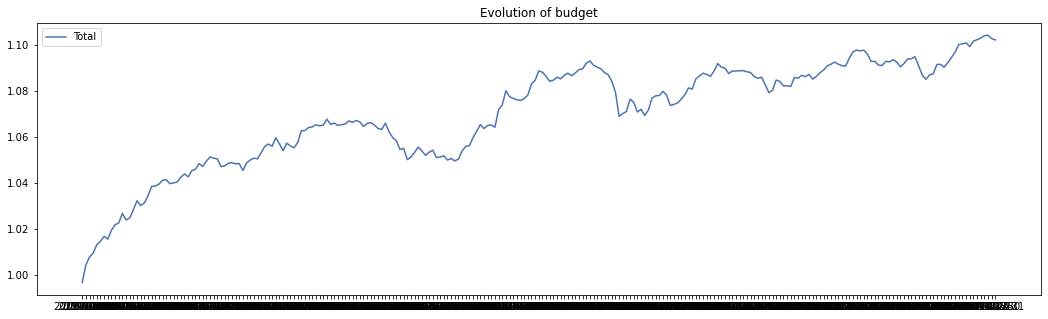

In [10]:
import random

N_ = random.randint(5,20)
train_random = train.sample(n=N_,axis=1)
test_ = test.pct_change().dropna()

def rd(n, total_sum):
    nums = np.random.rand(n)
    return nums/np.sum(nums)*total_sum

random_weights = rd(N_,1)

random_weights_dict = {}

for i,j in enumerate(train_random.columns):
    random_weights_dict[j] = random_weights[i]

choosen_funds_df = test_[random_weights_dict.keys()].copy()
# for i,j in enumerate(random_weights_dict.keys()):
#     choosen_funds_df[j] = choosen_funds_df[j] * list(random_weights_dict.values())[i] 
#     plt.plot(np.cumsum(choosen_funds_df[j]),label=j)

# plt.legend(loc='upper left')
# plt.title("Evolution of funds by weights")
pass

_ = test_rolling(random_weights_dict,test_,verbose=True)

In [36]:
first_results_df = pd.read_csv("First approach results.csv")
first_results_df.replace('-', 0,inplace=True)


In [37]:
first_results_df

,Method,Expected annual return %,Number of funds,Test return %,Variance
0,Random_di1,0,1,13.94,104.99
1,Random_di30,0,30,13.59,4.22
2,CVaR_r0.5,8.3,25,18.87,0
3,CVaR_r5,10.5,20,20.21,0
4,CVaR_r30,12,19,20.98,0
5,CVaR_r50,12.4,19,21.52,0
6,CDaR_r0.5,8.1,28,19.59,0
7,CDaR_r5,10.2,21,20.10,0
8,CDaR_r30,11.9,19,21.00,0
9,CDaR_r50,12.3,20,21.45,0


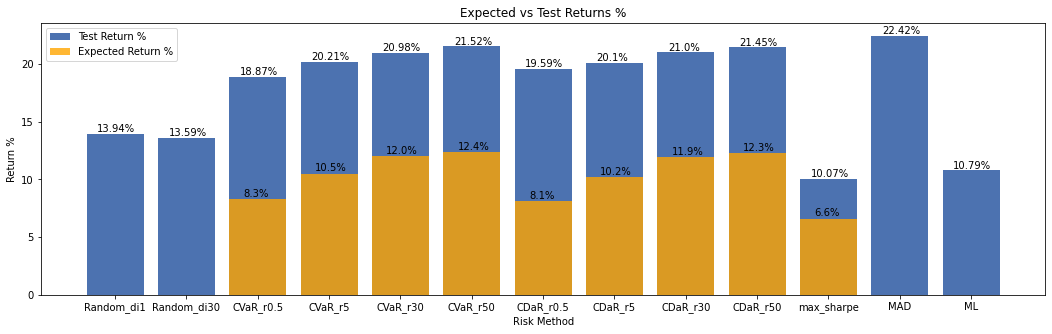

In [38]:
labels = first_results_df["Method"].values
expected_return = first_results_df["Expected annual return %"].values
for i,j in enumerate(expected_return):
    expected_return[i] = float(j)

test_return = first_results_df["Test return %"].values

plt.bar(labels,test_return,label="Test Return %")

for index, value in enumerate(test_return):
    plt.text(index-0.25, value+0.15, str(value)+"%")

plt.bar(labels,expected_return,label="Expected Return %",color="orange",alpha=0.8)

for index, value in enumerate(expected_return):
    if value != 0:
        plt.text(index-0.2, value+0.2, str(value)+"%")
    
plt.title("Expected vs Test Returns %")
plt.xlabel("Risk Method")
plt.ylabel("Return %")
plt.legend(loc='upper left')



In [129]:
import random

def random_test(train,test,iterations,n_splits,print_every):
    
    random_gains = []
    
    for i in range(0,iterations):
        
        if ((i+1) % print_every == 0):
            print(i+1,"out of",iterations)
            
        N_ = n_splits
        train_random = train.sample(n=N_,axis=1)
        test_ = test.pct_change().dropna()

        def rd(n, total_sum):
            nums = np.random.rand(n)
            return nums/np.sum(nums)*total_sum

        random_weights = rd(N_,1)

        random_weights_dict = {}

        for i,j in enumerate(train_random.columns):
            random_weights_dict[j] = random_weights[i]

        choosen_funds_df = test_[random_weights_dict.keys()].copy()
        # for i,j in enumerate(random_weights_dict.keys()):
        #     choosen_funds_df[j] = choosen_funds_df[j] * list(random_weights_dict.values())[i] 
        #     plt.plot(np.cumsum(choosen_funds_df[j]),label=j)

        # plt.legend(loc='upper left')
        # plt.title("Evolution of funds by weights")
        pass

        test_returns = test_rolling(random_weights_dict,test_,verbose=False)
        random_gains.append(round(test_returns[-1]*100,2))
        
    return random_gains
 
train_splitted = pd.read_csv("prices_train.csv").sample(n=500,axis=1,random_state=40)
random_gains1 = random_test(train,test,20000,1,500)
random_gains30 = random_test(train,test,20000,30,500)

500 out of 20000
1000 out of 20000
1500 out of 20000
2000 out of 20000
2500 out of 20000
3000 out of 20000
3500 out of 20000
4000 out of 20000
4500 out of 20000
5000 out of 20000
5500 out of 20000
6000 out of 20000
6500 out of 20000
7000 out of 20000
7500 out of 20000
8000 out of 20000
8500 out of 20000
9000 out of 20000
9500 out of 20000
10000 out of 20000
10500 out of 20000
11000 out of 20000
11500 out of 20000
12000 out of 20000
12500 out of 20000
13000 out of 20000
13500 out of 20000
14000 out of 20000
14500 out of 20000
15000 out of 20000
15500 out of 20000
16000 out of 20000
16500 out of 20000
17000 out of 20000
17500 out of 20000
18000 out of 20000
18500 out of 20000
19000 out of 20000
19500 out of 20000
20000 out of 20000
500 out of 20000
1000 out of 20000
1500 out of 20000
2000 out of 20000
2500 out of 20000
3000 out of 20000
3500 out of 20000
4000 out of 20000
4500 out of 20000
5000 out of 20000
5500 out of 20000
6000 out of 20000
6500 out of 20000
7000 out of 20000
7500 out 

In [142]:
for i,j in enumerate(random_gains30):
    if j > 35:
        random_gains30[i] = np.mean(random_gains30)

Mean: 13.956856567346772
Variance: 4.024145470122779
Min value: 6.79
Max value: 35.06
95% Quantile: 17.24
75% Quantile: 15.31
25% Quantile: 12.6
5% Quantile: 10.6795


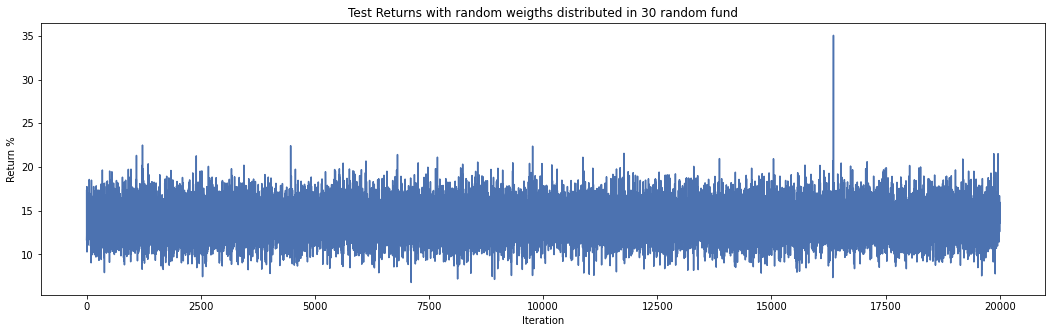

In [361]:
plt.plot(random_gains30)
print("Mean:",np.mean(random_gains30))
print("Variance:",np.var(random_gains30))
print("Min value:",min(random_gains30))
print("Max value:",max(random_gains30))
plt.title("Test Returns with random weigths distributed in 30 random fund")
plt.xlabel("Iteration")
plt.ylabel("Return %")
print("95% Quantile:",np.quantile(random_gains30, 0.95))
print("75% Quantile:",np.quantile(random_gains30, 0.75))
print("25% Quantile:",np.quantile(random_gains30, 0.25))
print("5% Quantile:",np.quantile(random_gains30, 0.05))
pass

Mean: 13.988455499999999
Variance: 90.30612679951976
Min value: -52.52
Max value: 70.86
95% Quantile: 29.49049999999999
75% Quantile: 21.87
25% Quantile: 6.387499999999999
5% Quantile: 0.54


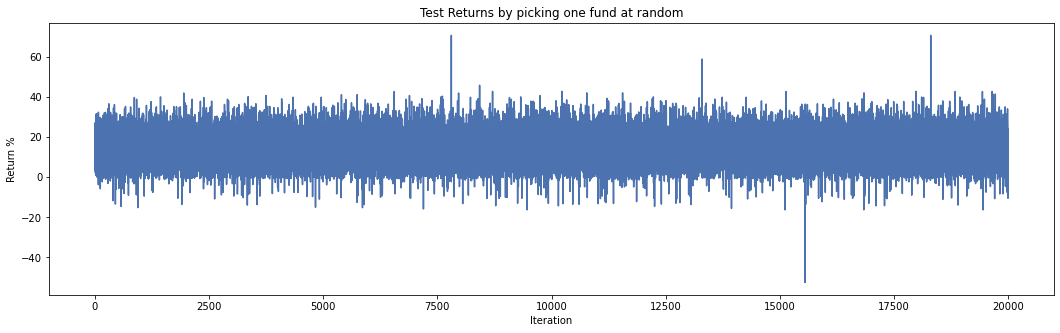

In [360]:
plt.plot(random_gains1)
print("Mean:",np.mean(random_gains1))
print("Variance:",np.var(random_gains1))
print("Min value:",min(random_gains1))
print("Max value:",max(random_gains1))
plt.title("Test Returns by picking one fund at random")
plt.xlabel("Iteration")
plt.ylabel("Return %")
print("95% Quantile:",np.quantile(random_gains1, 0.95))
print("75% Quantile:",np.quantile(random_gains1, 0.75))
print("25% Quantile:",np.quantile(random_gains1, 0.25))
print("5% Quantile:",np.quantile(random_gains1, 0.05))
pass

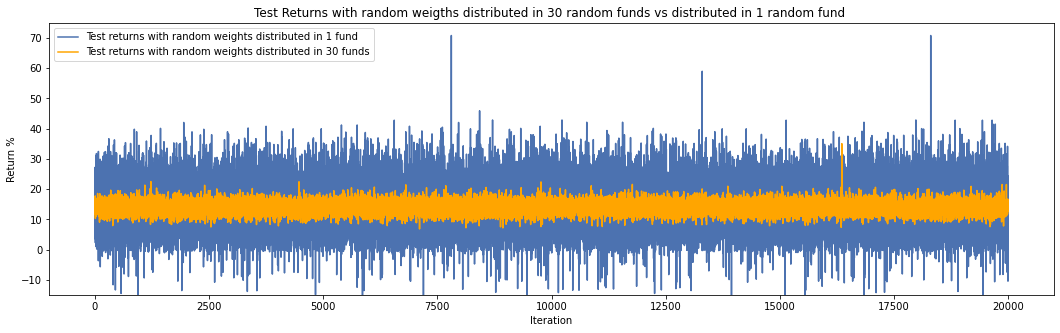

In [362]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 20000, 20000)
ax.plot(x, random_gains1,label="Test returns with random weights distributed in 1 fund")
plt.ylim(-15, 75)

plt.plot(random_gains30,color="orange",label="Test returns with random weights distributed in 30 funds")
plt.title("Test Returns with random weigths distributed in 30 random funds vs distributed in 1 random fund ")
plt.xlabel("Iteration")
plt.ylabel("Return %")
plt.legend(loc='upper left')

In [5]:
def Hierarchical_Computing(train,test,n_steps=2,min_weight=0,add_leftovers=False,split_size=100,print_every=50,
                           market_neutral=False,method="CVaR",budget=100,risk=0.005,gamma=0.1,verbose=True):
    
    for step in range(0,n_steps):
          
        if step == 0:    
            
            if verbose:
                print("Iteration 1")
                print("-----------")
            
            train_all_splits = []
            n_splits = int(np.ceil(len(train.columns)/split_size))

            for i in range(0,n_splits): 
                train_all_splits.append(train.iloc[:,i*split_size:(i+1)*split_size])

            selected_funds = []
            for counter,train_ in enumerate(train_all_splits):
                
                if verbose and (counter+1)%print_every == 0:
                    print(f"{counter+1} out of {n_splits}")
                try:
                    weights = test_pipeline(train_,test,market_neutral=False,method=method,
                                            min_weight=min_weight,add_leftovers=True,risk=risk,
                                            budget=budget,gamma=gamma,verbose=False)
                except:
                    print("Error at position:",counter, "solving with gamma=0 for this partition")
                    weights = test_pipeline(train_,test,market_neutral=False,method=method,
                                            min_weight=min_weight,add_leftovers=True,risk=risk
                                            ,budget=budget,gamma=0,verbose=False)

                for i in weights.keys():
                    selected_funds.append(i)

            if verbose:
                print(f"Selected funds in step 1: {len(selected_funds)} \n")
        
        else:
            
            if verbose:
                print(f"Iteration {step+1}")
                print("-----------")
            
            train_all_splits = []
            n_splits = int(np.ceil(len(train[selected_funds].columns)/split_size))

            for i in range(0,n_splits): 
                train_all_splits.append(train[selected_funds].iloc[:,i*split_size:(i+1)*split_size])

            selected_funds = []
            for counter,train_ in enumerate(train_all_splits):
                
                if verbose and (counter+1)%(print_every//(step+1)) == 0:
                    print(f"{counter+1} out of {n_splits}")
                    
                try:
                    weights = test_pipeline(train_,test,market_neutral=False,method=method,
                                            min_weight=min_weight,add_leftovers=True,risk=risk,
                                            budget=budget,gamma=gamma,verbose=False)
                except:
                    print("Error at position:",counter)
                    weights = test_pipeline(train_,test,market_neutral=False,method=method,
                                            min_weight=min_weight,add_leftovers=True,risk=risk,
                                            budget=budget,gamma=0,verbose=False)

                for i in weights.keys():
                    selected_funds.append(i) 

            if verbose:
                print(f"Selected funds in step {step+1}: {len(selected_funds)} \n")

    return selected_funds

In [27]:
selected_funds = Hierarchical_Computing(train,test,market_neutral=False,n_steps=2,split_size=100,print_every=20,
                                        min_weight=0.001,add_leftovers=False,method="CVaR",risk=0.005,gamma=0.2)

Iteration 1
-----------
20 out of 33
Error at position: 29 solving with gamma=0 for this partition
Selected funds in step 1: 589 

Iteration 2
-----------
Selected funds in step 2: 110 



In [29]:
weights = test_pipeline(train[selected_funds],test,market_neutral=False,
                        min_weight=0.04,add_leftovers=True,samples=0,method="CVaR",
                        risk=0.005,budget=500,gamma=0.15,rs=40) #Methods = CDaR, CVaR, sharpe, MAD, ML

print("Sum of weights =",sum(weights.values()))

Using CVaR method
Using pyomo...
Optimization time: 12.644261121749878 seconds
Budget not inverted: 0.0$
Volatility obtained in test: 0.028279295137249014
Total return obtained in the test year: 12.65%
Money obtained during test year: 63.23$
Distributed in 9 funds:
{'LEMANIK SICAV GLB STRATEGY"R"(USDHDG)ACC': 0.21166944716590133, 'MAN GLG ALPHA SELECT "ILH" (USDHDG)': 0.18425894769189324, 'MFS MERIDIAN EMRG MKTS DEBT "A1" (GBP)': 0.14812250418241327, 'ASSI - FRONTIER MKTS BD X USD ACC': 0.08583690328679607, 'BNY MELLON INTERNATIO (GBP) D': 0.08086711073355289, 'LO FUNDS GENERATION GLOBAL "M" (USD)': 0.07627167413583784, 'INVESTEC AMERICAN FRA "I" (USD) D': 0.0748264056739197, 'MERIAN UK SMALLER COM "R" (GBP) D A': 0.07438014915501344, 'ESPA STOCK RUSSIA "VT" ACC': 0.06376685797467231}


Sum of weights = 1.0


In [244]:
first_results_df = pd.read_csv("First approach Herarchical.csv")
first_results_df.replace('-', 0,inplace=True)

first_results_df['Volatility %'] = pd.to_numeric(first_results_df['Volatility %'])

In [245]:
first_results_df

,Method,Expected annual return %,Number of funds,Test return %,Volatility %
0,Random_di1,0,1,13.94,90.0
1,Random_di30,0,30,13.59,4.0
2,CVaR_r0.5,19.4,9,28.14,16.0
3,CVaR_r5,20.1,9,28.41,16.6
4,CVaR_r30,22.9,10,26.95,15.4
5,CVaR_r50,23.5,9,21.52,15.2
6,CDaR_r0.5,19,9,26.76,16.1
7,CDaR_r5,20.1,9,28.54,16.6
8,CDaR_r30,22.2,7,30.63,17.8
9,CDaR_r50,22.5,8,30.26,17.0


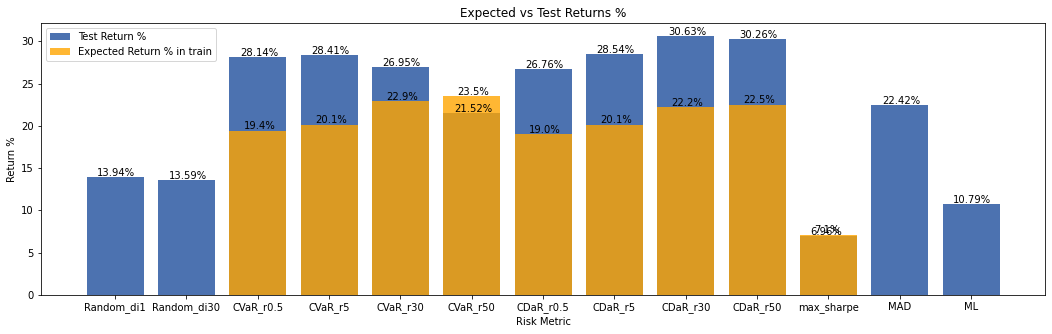

In [363]:
labels = first_results_df["Method"].values
expected_return = first_results_df["Expected annual return %"].values
for i,j in enumerate(expected_return):
    expected_return[i] = float(j)

test_return = first_results_df["Test return %"].values

plt.bar(labels,test_return,label="Test Return %")

for index, value in enumerate(test_return):
    plt.text(index-0.25, value+0.15, str(value)+"%")

plt.bar(labels,expected_return,label="Expected Return % in train",color="orange",alpha=0.8)

for index, value in enumerate(expected_return):
    if value != 0:
        plt.text(index-0.2, value+0.2, str(value)+"%")
    
plt.title("Expected vs Test Returns %")
plt.xlabel("Risk Metric")
plt.ylabel("Return %")
plt.legend(loc='upper left')



Text(0, 0.5, 'Volatility %')

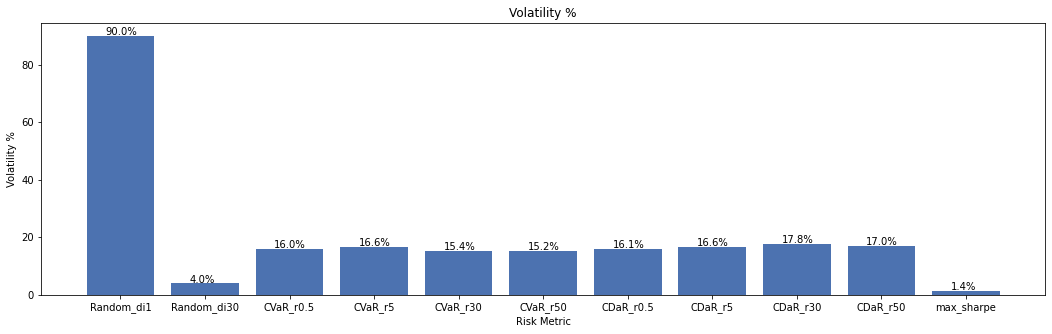

In [253]:
labels = first_results_df["Method"][:-2].values

plt.bar(labels,first_results_df["Volatility %"][:-2],label="Volatility %")

for index, value in enumerate(first_results_df["Volatility %"][:-2]):
    plt.text(index-0.18, value+0.3, str(value)+"%")

plt.title("Volatility %")
plt.xlabel("Risk Metric")
plt.ylabel("Volatility %")


## Simplex

In [ ]:
prices_df_main = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")

prices_df_main.dropna(inplace=True)
prices_df_main.set_index("Unnamed: 0",inplace=True)
prices_df_main.index.name= 'date'
N=1000
prices_df_main = prices_df_main.sample(n=N,axis=1,random_state=40)

rate_return_df = prices_df_main.pct_change().dropna()
rate_return_df

,"INVESCO PAN EUROPEAN STRUCTURED EQ ""E""","INVESCO REAL RETN (EUR) BD ""C"" (EUR) ACC","PIMCO EURO INCOME BOND ""E"" (EUR) INC","LEGG MASON WESTERN ASSET MACRO OPPORTUNITIES BOND ""X"" (USD) INC",FRANKLIN GLOBAL FUNDAMENTAL STRATEGIES A,"PRIVILDG WELL LG CAP US RSEARCH ""N""(USD)","GAM STAR (LUX) CONVERTIBL ALPH ""D"" (EUR)","FRANKLIN K2 ALTERNATIVE STRAT ""I"" (USD)","ARTEMIS FUNDS (LUX) U ""FI"" (USD) A","CANDRIAM SUSTAINABLE MEDIUM ""C"" INC",ASSI EM MKTS CORP BD I USD ACC,"FRANKLIN US GOVERNMENT ""I"" D","JAN HEN US VENTURE ""A"" (USD) ACC","GAM MULTISTOCK EMERGI ""R"" (CHF)","BNP GER MULTI-FACTOR EQ ""C"" (EUR) INC","DPAM INV B EQ EURLND ""F"" (EUR) ACC","BNY MELLON GBAL HIGH YIELD BOND ""C""(EUR)","BNY MELLON EM.MKT DEBT LCAL CUR ""C""(EUR)","ECHIQUIER WORLD EQUITY GROWTH ""A""","ALLIANZ CAPITAL PLUS ""CT"" (EUR)","VANGUARD GB ST BD IDX ""I"" (EURHDG)","AMUNDI VOLATILITY EURO ""F2"" (EUR) ACC","FIDELITY CHINA FOCUS ""Y""","NN (L) US ENH CORE CONCT EQ ""P"" (US) ACC","JPM EM INVESTMNT GRADE BND ""C"" (USD) ACC","MFS MERIDIAN US CORP BD ""A1"" (USD) ACC","CARMIGNAC PROFIL REACTIF 50 (EUR) ""A"" AC","LO FUNDS - ALL ROADS ""P"" (CHFHDG) ACC A","PICTET EUROPEAN EQ SEL ""I"" (EUR) D DY","FRANKLIN K2 ALT STRATEGIES ""I"" (JPY)","BGF EURO SH DUR BD ""A4R"" (USDHGD) D","NORDEA 1 NORDIC IDEAS EQUITY ""BI"" (EUR)","SCHRODER ISF EU ALPHA AB RT ""A"" (USDHDG)","VANGUARD EURO GOV BD IDX ""I"" (USD)","JB STRATEGY INCOME (USD) ""A"" (USD) INC","SCHRODER ISF GLOBAL EQUITY ""B""","DWS CONCEPT KALDEMORGEN ""VC"" (EUR) ACC","FRONTIER MARKETS ""R-CL"" (EUR) ACC","INVESCO EM MKT STRUC EQ ""A"" (USD) ACC","TEMPLETON GLOBAL TOTAL RETURN ""A"" INC",...,"BNP GLOBAL INF-LINKED BD ""I"" (EUR) ACC","MULTICOOPERATION SICA ""B"" (USDHDG)","CS (LUX) ASIA CORPORA ""EA"" (USD) D","FIDELITY GLB DEMOGRAPHICS ""A""","GAM MULTIBOND LOCAL E ""C"" (GBPHDG)","DWS INVEST II GLOBAL ""FC"" (EUR)",COMGEST GROWTH EMERGING MARKETS (EUR) D,"BGF EMERGING MARKETS ""D2"" (EUR)","SCHRODER ISF GLB CLIM CH ""A1"" (EURHDG)",ASSI EM MKTS SM CO X EUR ACC,"VANGUARD EUR I GR BD IX ""INV"" (EUR)",AB FCP I-ASIA EX-JAP EQ PFOLIO 'A' (EUR),"CS DURACION 0-2, FI""B"" (EUR) ACC","PICTET SHORT-TERM MONEY MKT(EUR) ""P"" INC","NN (L) EM DEBT (LC) ""X"" (EURHDG) ACC","SCHRODER ISF GLOBAL CRE ""A"" (USD) ACC","VANGUARD GLOBAL S-T BD IND ""IP"" (USDHDG)",OYSTER GBL HGH YD 'I CHF HP' (CHFHDG)ACC,"BNY MELLON GLOBAL REAL RETURN (EUR) ""C""","GLOBALACCESS UK OPPOR ""A"" (EURHDG)","AXA IM FIIS EUR SHORT DUR HY ""E"" (EUR)","LO SELECTION THE BALA ""N"" (EUR)","BGF US DOLLAR RESERVE ""A2"" (GBP HDG) ACC","FIDELITY US DOLLAR CASH ""A"" D","FIDELITY EMGG MKT CORP DBT ""A"" (EURHDG)","FIDELITY GLB MULT ASST IN ""A""(USD) INC M","INVESTEC GLOBAL FRANC ""A"" (USDHDG)","NORDEA 1 NORDIC EQUITY SC ""BP"" (EUR)","BGF USD HIGH YLD BD ""A3"" (EURHGD) D","UBAM SWISS EQUITY ""I"" (EURHDG)","INVESCO PAN EUR STRUCT EQ ""A"" (EURHDG)","GAM MULTISTOCK ABSOLU ""A"" (CHFHDG) D","EI STURDZA STRTGC EURP QL ""I"" (EUR) A","THREADNEEDLE EMERG MRKT LOC ""1"" RNI D","MAN GLG EUROPEAN MID- ""INF"" (EUR)","BLENDED RESEARCH EURP EQ ""A1"" (USD) ACC",IMANTIA FUTURO HEALTH (EUR),"M&G (LUX) EURO ST VAL ""A"" (USD)","SABADELL BONOS EMERGENTES, PLUS","AXA WF EURO CREDIT PLUS ""E"" (EUR)Q D"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.002024,-0.003309,0.000000,0.000614,0.000826,0.000847,-0.001525,0.000000,-0.001934,-0.008031,-0.000732,0.000000,0.002491,0.007716,0.001967,0.002791,0.010381,0.007975,0.012215,0.000000,0.000231,-0.002007,-0.001377,0.002094,0.001242,0.000000,0.003306,0.001552,-0.022977,-0.002821,0.000000,-0.002713,0.004291,-0.006487,0.000839,-0.002179,0.003935,-0.000712,-0.005814,0.004430,...,0.000206,0.000855,0.001571,0.004054,0.000902,0.008842,0.009434,0.007909,-0.006869,0.005819,0.001087,0.009642,0.000072,0.000000,0.005827,-0.009970,0.000282,0.003596,0.002602,0.006689,-0.000654,0.003619,0.000052,0.000000,0.001967,0.001553,0.002679,-0.007027,-0.003240,0.005429,0.

In [ ]:
betas = np.random.normal(0, 0.01, N)
mean_daily_returns = np.array(-rate_return_df.mean()) # C

In [ ]:
from scipy.optimize import linprog
# SIMPLEX
N = len(prices_df_main.columns)
rate_return_df = prices_df_main.pct_change().dropna()



# Since we are maximizing, and sklearn always minimize the objective function, I have set a minus sign on the mean returns. --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html


A = np.array([])
b= np.array([])

# Constrain 4: sum(weights) <= 1   
eq_one = np.array([1]*N)
A = np.array([eq_one])
b= np.array([1])
# Constraint 5: Let´s assume we are using CVaR as risk measure. 

# Costraint 6: Assume random vector of betas
betas = np.random.normal(0, 0.01, N)
A = np.array([eq_one,betas,-betas])
K = 0.001
b= np.array([1,K,K])   # K = 0.1 

# 
# weights = np.random.random(N)
# weights /= np.sum(weights)

sol = linprog(mean_daily_returns, A_ub=A, b_ub=b, bounds=(0, 1))
print()
weights = []
for w in sol.x:
  weights.append(round(w,4))

for indx in range(N):
  if weights[indx] > 0:
    print(str(prices_df_main.columns[indx]),':',weights[indx])

print('\nExpected annual return:: ',round(-sol.fun*100,3),'%')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



JAN HH GLOBAL TECHNOLOGY "A2" (GBP) ACC : 0.7759
FINALTIS DIGITAL LEADERS "R" (EUR) INC : 0.2237

Expected annual return::  0.076 %


## Pyomo 

In [139]:
!pip install pyomo      
!apt-get install -y -qq glpk-utils

     |████████████████████████████████| 9.1 MB 32.7 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 


In [140]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

In [3]:
prices_df_main = pd.read_csv("prices_test.csv")

prices_df_main.dropna(inplace=True)
prices_df_main.set_index("Unnamed: 0",inplace=True)
prices_df_main.index.name= 'date'
prices_df_main = prices_df_main.sample(n=100,axis=1,random_state=40)

with open('working_dates_train&test.txt') as f:
    contents = f.read()


dates_ = contents.split("\n")[755:-1] #Working dates for both
N = len(prices_df_main.columns)
betas = np.random.normal(0, 0.01, N)

In [4]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

# IMPORTANT! CHOOSE THE RISK METRIC

rsk_metric = 'CVaR'      # CVaR, CDaR, MAD, ML

J = len(dates_)
rate_return_df = prices_df_main.pct_change().dropna()
mean_daily_returns = np.array(rate_return_df.mean()) # C

model = ConcreteModel()

model.Weights = RangeSet(0,N-1)
model.Y = RangeSet(0,J-1)
model.x = Var(model.Weights, domain=NonNegativeReals,bounds=(0,1))

def obj_expression(model): 
    return sum(model.x[i]*mean_daily_returns[i] for i in model.Weights)

model.OBJ = Objective(rule=obj_expression, sense=maximize)

def sum_one(model): 
    return sum(model.x[i] for i in model.Weights) <= 1
model.cons1 = Constraint(rule=sum_one)


# CONSTRAINT 5: RISK MANAGEMENT CONSTRAINT
W = 0.01
if rsk_metric == 'CVaR':
    ### CVaR 
    model.slack = Var()
    alpha = 0.95  # Confidence level 
    model.w = Var(model.Y,domain=NonNegativeReals)

    def dummy_cons(model):
      return model.slack + (1/(1-alpha))*(1/J)*sum(model.w[j] for  j in model.Y) <= W

    model.cons1_CVaR = Constraint(rule = dummy_cons) 

    def c5_CVaR(model,j):
        date = dates_[j]
        return -sum(rate_return_df.loc[date][i] *model.x[i] for i in model.Weights )- model.slack <= model.w[j]
    model.cons2_CVaR = Constraint(model.Y,rule = c5_CVaR) 



if rsk_metric == 'ML':
    ### MAX LOSS
    model.w = Var(RangeSet(0,0),domain=NonNegativeReals,bounds=(0,1))

    def dummy_cons(model):
      return model.w[0] <= W
    model.cons1_ML = Constraint(rule = dummy_cons) 

    def c5_MaxLoss(model,j):
        date = dates_[j]
        return -sum(rate_return_df.loc[date][i] *model.x[i] for i in model.Weights ) <= model.w[0]
    model.cons2_ML = Constraint(model.Y,rule = c5_MaxLoss)  



# CONSTRAINT 6: MARKET NEUTRALITY
# betas = np.random.normal(0, 0.01, N)
K = 0.001
def market_neutral_upper(model): 
    return sum(model.x[i]*betas[i] for i in model.Weights) <= K
model.cons2 = Constraint(rule=market_neutral_upper)

def market_neutral_lower(model): 
    return sum(model.x[i]*betas[i] for i in model.Weights) >= -K

model.cons3 = Constraint(rule=market_neutral_lower)


Results = SolverFactory('glpk').solve(model)


print('\nPortfolio´s Funds:')
for i in model.x:     
  if model.x[i].value > 0:
    print(str(prices_df_main.columns[i]),':',model.x[i].value)


print('\nObjetive Function')
display(model.OBJ)

print('\nWeight Constraint (less equal to 1)')
display(model.cons1 ) 

print('\nConstraint 5 (Risk of the Inversion)')

if rsk_metric == 'CVaR':
  print('CVaR Approach')
  display(model.cons1_CVaR ) 
  display(model.cons2_CVaR ) 

if rsk_metric == 'ML':
  print('MaxLoss Approach')
  display(model.cons1_ML ) 
  display(model.cons2_ML) 

print('\nConstraint 6 (Market Neutrality)')
display(model.cons2 ) 
display(model.cons3 )


Portfolio´s Funds:
ARTEMIS FUNDS (LUX) U "FI" (USD) A : 0.519541960966166
JPM EM INVESTMNT GRADE BND "C" (USD) ACC : 0.269808203271757
DPAM INV B EQ EUR SUSTNBL "A" (EUR) INC : 0.0831983476266238
NN (L) GREATER CHINA EQUITY "P" (USD) A : 0.12745148813545

Objetive Function
OBJ : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.0010370220441692514

Weight Constraint (less equal to 1)
cons1 : Size=1
    Key  : Lower : Body               : Upper
    None :  None : 0.9999999999999969 :   1.0

Constraint 5 (Risk of the Inversion)
CVaR Approach
cons1_CVaR : Size=1
    Key  : Lower : Body                : Upper
    None :  None : 0.00999999999999994 :  0.01
cons2_CVaR : Size=251
    Key : Lower : Body                    : Upper
      0 :  None :   -0.002726235158771153 :   0.0
      1 :  None :    -0.01606201342797319 :   0.0
      2 :  None :   -0.014946629675122681 :   0.0
      3 :  None :   -0.014595845754771013 :   0.0
      4 :  None :   -0.01356654062498

# Checking that IronIA's max_drawdown == our drawdown calculation

In [ ]:
sql = 'SELECT * FROM `ironia-data.Ironia_Ext.ratios` WHERE allfunds_id=169523 AND ratio="max_drawdown" AND period="3y" LIMIT 10000'
df_try = pd.read_gbq(sql)
df_try.set_index("date")
df_try["date"] = pd.to_datetime(df_try["date"])
df_try = df_try.sort_values(by="date")

In [ ]:
df_try

,allfunds_id,benchmark_id,date,period,ratio,value_product,value_benchmark,benchmark_name
26,521040,58878f27c11e3870353bca03,2021-01-27,3y,max_drawdown,-0.576298,-0.415663,Ibex 35
8,521040,58878f27c11e3870353bca03,2021-02-03,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
29,521040,58878f27c11e3870353bca03,2021-02-10,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
25,521040,58878f27c11e3870353bca03,2021-02-17,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
24,521040,58878f27c11e3870353bca03,2021-02-17,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
23,521040,58878f27c11e3870353bca03,2021-02-24,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
15,521040,58878f27c11e3870353bca03,2021-03-03,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
0,521040,58878f27c11e3870353bca03,2021-03-10,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
33,521040,58878f27c11e3870353bca03,2021-03-17,3y,max_drawdown,-0.575108,-0.405417,Ibex 35
11,521040,58878f27c11e3870353bca03,2021-03-24,3y,max_drawdown,-0.575108,-0.405417,Ibex 35


In [ ]:
sql = "SELECT * FROM `ironia-data.Ironia_Ext.precios` WHERE Ironia_id=169523 LIMIT 100000000"
df_try2 = pd.read_gbq(sql)
df_try2["date"] = pd.to_datetime(df_try2["date"])
df_try2 = df_try2.sort_values(by="date")
df_try2.set_index("date",inplace=True)

In [ ]:
df_try2 = df_try2["2017-01-01":"2021-01-01"] 
max_acum = df_try2["nav"].cummax()
df_try2["drawdown"] = -(df_try2["nav"]-max_acum)/max_acum
MDD =  np.max(df_try2["drawdown"].values)
print(round(MDD,6))

0.440761


In [ ]:
today = date.today()
today.isoformat()

'2021-10-21'

In [ ]:
years_ago = date.today() - relativedelta(years=5)

# Predicting using prophet

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/IronIA/prices_train.csv")
train.set_index("Unnamed: 0",inplace=True)
train.index.name= 'date'
test = pd.read_csv("/content/drive/MyDrive/IronIA/prices_test.csv")
test.set_index("Unnamed: 0",inplace=True)
test.index.name= 'date'

In [ ]:
fund = 670

series = train.copy() 
series['ds']  = pd.to_datetime(series.index)
series['y'] = series[[train.columns[fund]]].astype(float)
series = series[["ds","y"]]
series.head()

,ds,y
date,,
2016-01-04,2016-01-04,10.56
2016-01-05,2016-01-05,10.50
2016-01-06,2016-01-06,10.34
2016-01-07,2016-01-07,10.15
2016-01-08,2016-01-08,10.19


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


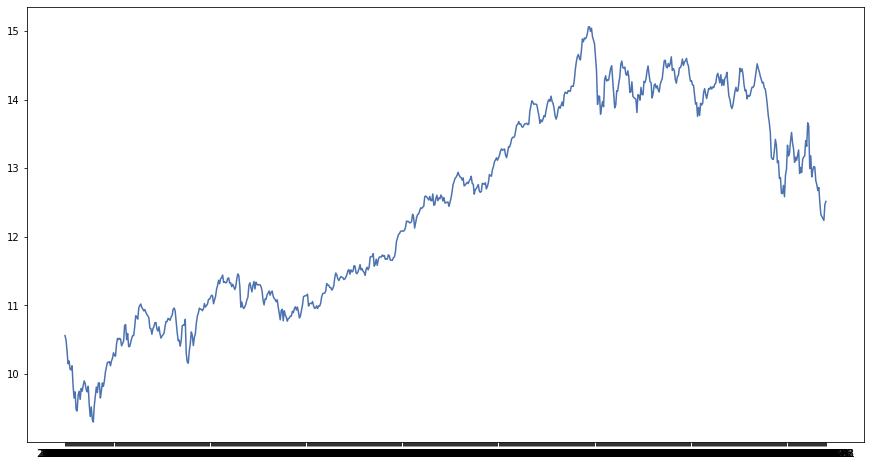

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(train[train.columns[fund]])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


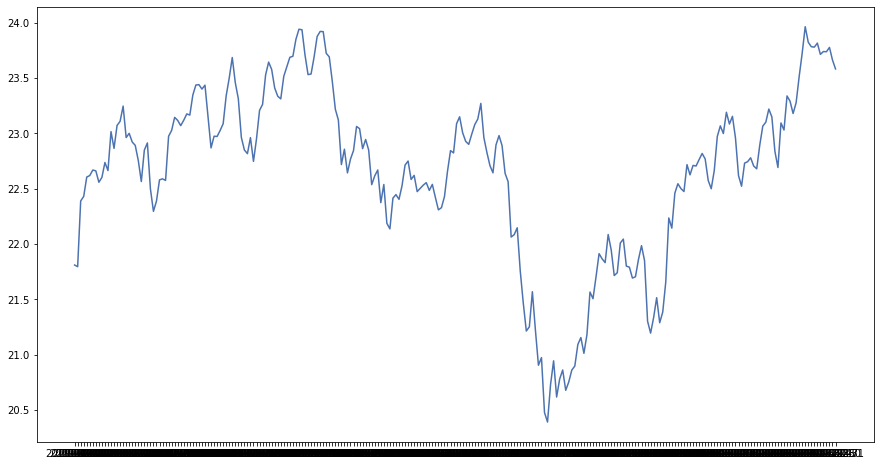

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(test[train.columns[0]])

In [ ]:
from fbprophet import Prophet

m = Prophet(mcmc_samples=0,daily_seasonality=False,seasonality_mode='additive').fit(series);

future = m.make_future_dataframe(periods=1,freq='Y')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
750,2018-12-26,-4.274834,12.390176,12.885387,-24.713321,16.990736,16.907116,-4.385172,37.279716,17.370294,-3.953223,37.789215,-0.463178,-0.520968,-0.400727,0.0,0.0,0.0,12.632281
751,2018-12-27,-4.279960,12.371301,12.902044,-24.719258,16.984870,16.918232,-4.357118,37.290208,17.374816,-3.944108,37.769958,-0.456584,-0.514417,-0.395371,0.0,0.0,0.0,12.638272
752,2018-12-28,-4.285085,12.374945,12.887528,-24.725194,16.979003,16.921375,-4.327147,37.282564,17.368461,-3.937420,37.763076,-0.447087,-0.506735,-0.384768,0.0,0.0,0.0,12.636289
753,2018-12-31,-4.300462,12.398509,12.931131,-24.743003,16.961405,16.975016,-4.269977,37.321277,17.376978,-3.935668,37.806468,-0.401963,-0.464951,-0.338603,0.0,0.0,0.0,12.674554
754,2019-12-31,-6.171243,7.379714,14.101761,-27.223666,14.660124,16.967868,-4.287043,37.327362,17.374480,-3.939673,37.801538,-0.406612,-0.469003,-0.343021,0.0,0.0,0.0,10.796625


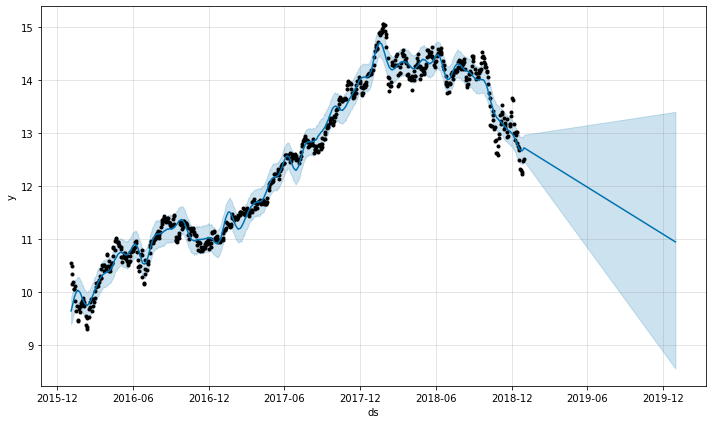

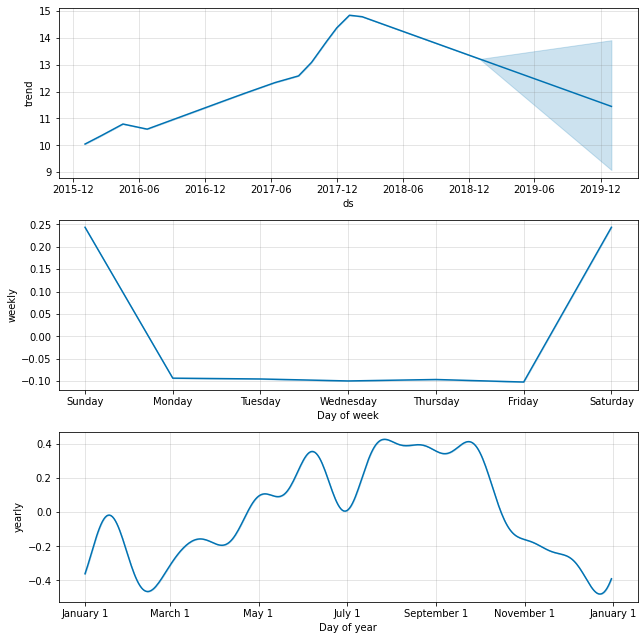

In [ ]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)